In [154]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
import time, gc
from tqdm import tqdm
gc.enable()
import matplotlib.pyplot as plt

In [162]:
def get_source_and_target_matrices(alignment_dict, entity2vec1, entity2vec2, given_test_set=None, emb_dim=200, test_size=0.2, scale=True, shift=True):
    """This function takes the dictionary of aligned entities between two KGs and their corresponding embeddings (as entity to vector dictionaries)
    and returns S, T, S_eval, T_eval, and R defined as follows:
    
    -- S: Normalized and scaled large subset of the source embeddings, i.e. the matrix of aligned entity embeddings in the first knowledge graph
    
    -- T: Normalized and scaled large subset of the matrix of aligned entity embeddings in the second knowledge graph
    
    -- S_eval and T_eval are portions of S and T sampled for evaluation if test_size > 0
    
    -- R: The rotation matrix that most closely maps S to T, i.e. ||A@S-T|| is minimized
    
    The mean and standard deviation of S, T are also returned
    """
    t0 = time.time()
    if test_size > 0:
        if given_test_set is None:
            train_ents, eval_ents = train_test_split(list(alignment_dict.keys()), test_size=test_size, random_state=42)
        else:
            eval_ents = given_test_set
            train_ents = list(set(alignment_dict.keys())-set(eval_ents))
    else:
        train_ents = alignment_dict.keys()
    
    S = np.empty((len(train_ents), emb_dim))
    T = np.empty((len(train_ents), emb_dim))
    if test_size > 0:
        S_eval = np.empty((len(eval_ents), emb_dim))
        T_eval = np.empty((len(eval_ents), emb_dim))

    for i, key in tqdm(enumerate(train_ents), total=len(train_ents), desc='Computing S and T'):
        S[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
        T[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    if test_size > 0:
        for i, key in tqdm(enumerate(eval_ents), total=len(eval_ents), desc='Computing S_eval and T_eval'):
            S_eval[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
            T_eval[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    print('\nNow computing R...')
    # Center and scale data
    mean_S = S.mean(axis=0)
    mean_T = T.mean(axis=0)
    scale_S = np.sqrt(((S-mean_S)**2).sum()/S.shape[0]) # scale, see https://en.wikipedia.org/wiki/Procrustes_analysis
    scale_T = np.sqrt(((T-mean_T)**2).sum()/T.shape[0])
    print('Scale S: ', scale_S)
    
    if shift and scale:
        R, loss = orthogonal_procrustes((S-mean_S)/scale_S, (T-mean_T)/scale_T, check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
    elif shift:
        R, loss = orthogonal_procrustes((S-mean_S), (T-mean_T), check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
    elif scale:
        R, loss = orthogonal_procrustes(S/scale_S, T/scale_T, check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
    else:
        R, loss = orthogonal_procrustes(S, T, check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
        
    print('Alignment loss: ', loss)
    if test_size > 0:
        if shift and scale:
            return scale_S, scale_T, mean_S, mean_T, (S-mean_S)/scale_S, (T-mean_T)/scale_T, (S_eval-mean_S)/scale_S, (T_eval-mean_T)/scale_T, R
        elif shift:
            return scale_S, scale_T, mean_S, mean_T, S-mean_S, T-mean_T, S_eval-mean_S, T_eval-mean_T, R
        elif scale:
            return scale_S, scale_T, mean_S, mean_T, S/scale_S, T/scale_T, S_eval/scale_S, T_eval/scale_T, R
        else:
            return scale_S, scale_T, mean_S, mean_T, S, T, S_eval, T_eval, R
    else:
        if shift and scale:
            return scale_S, scale_T, mean_S, mean_T, (S-mean_S)/scale_S, (T-mean_T)/scale_T, R
        elif shift:
            return scale_S, scale_T, mean_S, mean_T, S-mean_S, T-mean_T, R
        elif scale:
            return scale_S, scale_T, mean_S, mean_T, S/scale_S, T/scale_T, R
        else:
            return scale_S, scale_T, mean_S, mean_T, S, T, R
        
    

In [156]:
EnFr_shallom_embs_v1 = pd.read_csv('Shallom_EnFr_15K_V1/Shallom_entity_embeddings.csv')

In [157]:
Fr_shallom_embs_v1 = EnFr_shallom_embs_v1[EnFr_shallom_embs_v1['Unnamed: 0'].apply(lambda x: 'fr.dbpedia.org' in x)]

In [158]:
En_shallom_embs_v1 = EnFr_shallom_embs_v1.iloc[np.setdiff1d(np.arange(EnFr_shallom_embs_v1.shape[0]),\
                                                            np.array(Fr_shallom_embs_v1.index))].set_index('Unnamed: 0')

In [159]:
Fr_shallom_embs_v1 = Fr_shallom_embs_v1.set_index('Unnamed: 0')

In [160]:
with open('OpenEA_dataset_v1.1/EN_FR_15K_V1/ent_links') as file:
    en_to_fr_ents_v1 = file.read().strip().split('\n')
en_to_fr_ents_v1 = dict([line.split('\t') for line in en_to_fr_ents_v1])

In [163]:
scale_S, scale_T, mean_S, mean_T, S, T, R = get_source_and_target_matrices(en_to_fr_ents_v1,\
                                                                                    En_shallom_embs_v1, Fr_shallom_embs_v1, emb_dim=300, test_size=0.0)

Computing S and T: 100%|██████████| 15000/15000 [00:03<00:00, 4917.93it/s]



Now computing R...
Scale S:  7.246380617560009

Completed after 3.343036413192749 seconds
Alignment loss:  5129.7868504241305


## 2D

In [164]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [10]:
def search(string, Iterator_of_strings):
    string = string.replace(" ", "_")
    def __score(string1, string2):
        imax = len(string1)
        for i in range(1,imax+1)[::-1]:
            if string1[:i] in string2:
                return i
        return 0.0
    scores = {}
    for candidate in Iterator_of_strings:
        scores[candidate] = __score(string.lower(), candidate.lower())
    return sorted(list(scores.keys()), key=lambda x: -scores[x])

In [11]:
search("Trump", en_to_fr_ents_v1.keys())[:5]

['http://dbpedia.org/resource/A_Distant_Trumpet',
 'http://dbpedia.org/resource/Sounding_the_Seventh_Trumpet',
 'http://dbpedia.org/resource/Donald_Trump',
 'http://dbpedia.org/resource/Percussion_instrument',
 'http://dbpedia.org/resource/Anuthatantrum']

## Choose some entities and visualize embeddings

In [12]:
# physics, physicist, Nobel_prize_in_physics, Obama, Donald Trump

In [165]:
En_version = ['http://dbpedia.org/resource/Nobel_Prize_in_Physics', 
              'http://dbpedia.org/resource/Physics', 'http://dbpedia.org/resource/Physicist',
              'http://dbpedia.org/resource/Barack_Obama','http://dbpedia.org/resource/Donald_Trump'
             ]
chosen_entities = dict(list(filter(lambda x: x[0] in En_version, en_to_fr_ents_v1.items())))

In [14]:
chosen_entities

{'http://dbpedia.org/resource/Barack_Obama': 'http://fr.dbpedia.org/resource/Barack_Obama',
 'http://dbpedia.org/resource/Nobel_Prize_in_Physics': 'http://fr.dbpedia.org/resource/Prix_Nobel_de_physique',
 'http://dbpedia.org/resource/Donald_Trump': 'http://fr.dbpedia.org/resource/Donald_Trump',
 'http://dbpedia.org/resource/Physics': 'http://fr.dbpedia.org/resource/Physique',
 'http://dbpedia.org/resource/Physicist': 'http://fr.dbpedia.org/resource/Physicien'}

## Plot with t-SNE

In [166]:
import seaborn as sns
sns.set_theme(style="darkgrid")
from sklearn.manifold import TSNE

In [219]:
tsne = TSNE(n_components=2)
reduced_embs_fr = tsne.fit_transform(Fr_shallom_embs_v1.values)

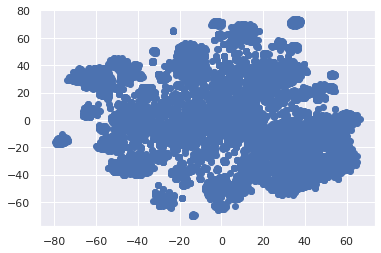

In [168]:
plt.scatter(reduced_embs_fr[:,0], reduced_embs_fr[:,1])
plt.savefig("fr_tsne_full.png")
plt.show()

In [220]:
reduced_embs_en = tsne.fit_transform(En_shallom_embs_v1.values)

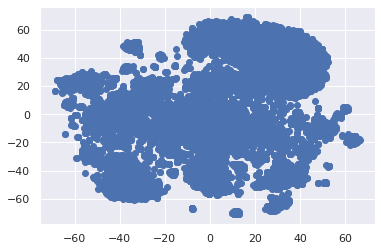

In [170]:
plt.scatter(reduced_embs_en[:,0], reduced_embs_en[:,1])
plt.savefig("en_tsne_full.png")
plt.show()

In [221]:
reduced_uni_embs = tsne.fit_transform((S@R+T)/2)

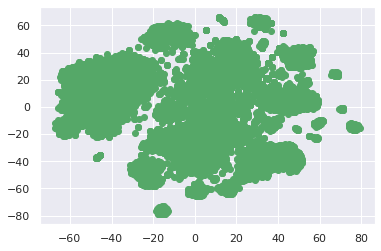

In [172]:
plt.scatter(reduced_uni_embs[:,0], reduced_uni_embs[:,1], color='g')
plt.savefig("universal_tsne_full.png")
plt.show()

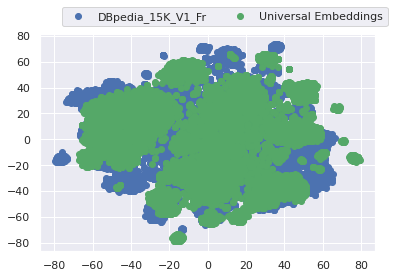

In [173]:
## Frenc embeddings vs Universal embeddings
plt.scatter(reduced_embs_fr[:,0], reduced_embs_fr[:,1]);
plt.scatter(reduced_uni_embs[:,0], reduced_uni_embs[:,1], color='g');
plt.legend(('DBpedia_15K_V1_Fr', 'Universal Embeddings'), bbox_to_anchor=(0.05, 1.15), loc='upper left', ncol=2);

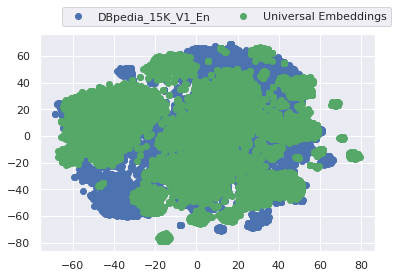

In [174]:
## English embeddings vs Universal embeddings
plt.scatter(reduced_embs_en[:,0], reduced_embs_en[:,1]);
plt.scatter(reduced_uni_embs[:,0], reduced_uni_embs[:,1], color='g');
plt.legend(('DBpedia_15K_V1_En', 'Universal Embeddings'), bbox_to_anchor=(0.05, 1.15), loc='upper left', ncol=2);

In [63]:
from sklearn.cluster import KMeans
num_clusters = 3
kmeans_fr = KMeans(n_clusters=num_clusters, random_state=0).fit(Fr_shallom_embs_v1.values)

In [64]:
kmeans_en = KMeans(n_clusters=num_clusters, random_state=0).fit(En_shallom_embs_v1.values)

In [65]:
kmeans_uni = KMeans(n_clusters=num_clusters, random_state=0).fit((S@R+T)/2)

In [68]:
from itertools import cycle
cycol = cycle('bgrcmk')
colors = [next(cycol) for _ in range(num_clusters)]

In [69]:
#colors = [0.90206152, 0.55780754, 0.65598471, 0.83247141, 0.19988419,
#       0.12725426, 0.77143911, 0.43228855]

In [146]:
import random
random.seed(142)
def plot_clusters(kmeans, tsne_decomposition1, tsne_decomposition2, sample_size, colors, name1="French DBpedia", name2="Universal Embeddings"):
    selected_indices = []
    list_colors = []
    clusters = []
    for i, cluster in enumerate(range(num_clusters)):
        indices = random.sample(np.where(kmeans.labels_==cluster)[0].tolist(), sample_size)
        selected_indices.extend(indices)
        clusters.append(indices)
        list_colors.extend([colors[i]]*sample_size)
    fig1, ax1 = plt.subplots()
    ax1.scatter(tsne_decomposition1[selected_indices][:,0], tsne_decomposition1[selected_indices][:,1], c=list_colors)
    plt.title(name1)
    fig2, ax2 = plt.subplots()
    ax2.scatter(tsne_decomposition2[selected_indices][:,0], tsne_decomposition2[selected_indices][:,1], c=list_colors)
    plt.title(name2)
    plt.show()
    return clusters, selected_indices

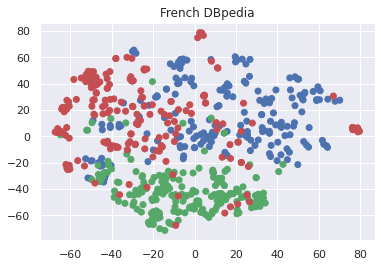

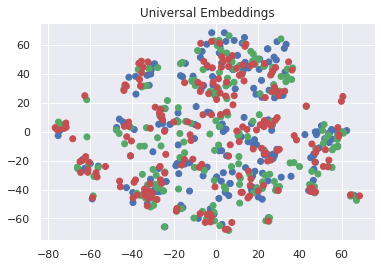

In [116]:
cluster_ids, selected_indices = plot_clusters(kmeans_fr, reduced_embs_fr, reduced_uni_embs, sample_size=200, colors=colors)

In [138]:
def show_universal_emb_clusters(uni_embs, tsne_decomposition, selected_indices, name="French"):
    list_colors = []
    data = uni_embs[selected_indices]
    new2old_ids = {i:selected_indices[i] for i in range(len(selected_indices))}
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(data)
    new_indices = []
    new_cluster_ids = []
    for i, cluster in enumerate(range(num_clusters)):
        indices = np.where(kmeans.labels_==cluster)[0].tolist()
        list_colors.extend([colors[i]]*len(indices))
        new_indices.extend(indices)
        new_cluster_ids.append(list(map(new2old_ids.get, indices)))
    fig1, ax1 = plt.subplots()
    to_old_ids = [new2old_id[i] for i in new_indices]
    ax1.scatter(tsne_decomposition[to_old_ids][:,0], tsne_decomposition[to_old_ids][:,1], c=list_colors)
    plt.title(f"Clusters in Universal Embeddings {name}")
    plt.show()
    return new2old_id, new_cluster_ids

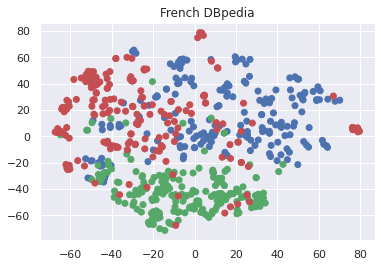

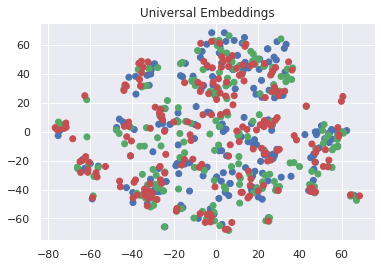

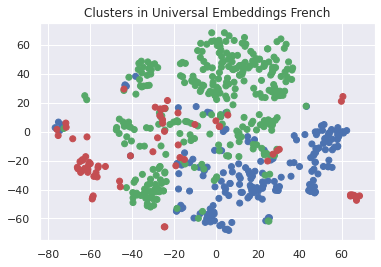

In [147]:
cluster_ids, selected_indices = plot_clusters(kmeans_fr, reduced_embs_fr, reduced_uni_embs, sample_size=200, colors=colors)
new2old_id, new_cluster_ids = show_universal_emb_clusters((S@R+T)/2, reduced_uni_embs, selected_indices)

In [148]:
entity_clusters_original_fr = [Fr_shallom_embs_v1.index[i].tolist() for i in cluster_ids]

In [149]:
entity_clusters_uni = [Fr_shallom_embs_v1.index[i].tolist() for i in new_cluster_ids]

In [153]:
import json

clusters_fr_original = {f"cluster-{c}": entity_clusters_original_fr[c] for c in range(len(entity_clusters_original_fr))}
clusters_fr_universal = {f"cluster-{c}": entity_clusters_uni[c] for c in range(len(entity_clusters_uni))}
with open("Clusters_Fr_original.json", "w") as file:
    json.dump(clusters_fr_original, file)
    
with open("Clusters_Fr_universal.json", "w") as file:
    json.dump(clusters_fr_universal, file)

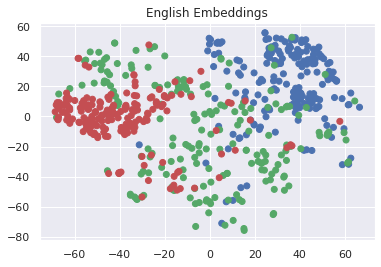

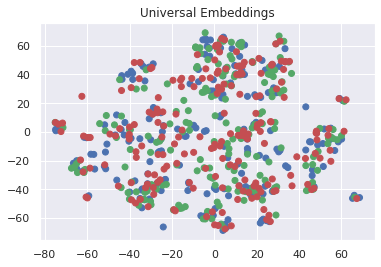

In [106]:
cluster_ids, selected_indices = plot_clusters(kmeans_en, reduced_embs_en, reduced_uni_embs, sample_size=200, colors=colors, name1="English Embeddings")

### Choose and visualize some entities

In [175]:
En_version = ['http://dbpedia.org/resource/Nobel_Prize_in_Physics', 
              'http://dbpedia.org/resource/Physics', 'http://dbpedia.org/resource/Physicist',
              'http://dbpedia.org/resource/Barack_Obama','http://dbpedia.org/resource/Donald_Trump'
             ]
chosen_entities = dict(list(filter(lambda x: x[0] in En_version, en_to_fr_ents_v1.items())))

In [180]:
names

['Barack_Obama',
 'Prix_Nobel_de_physique',
 'Donald_Trump',
 'Physique',
 'Physicien']

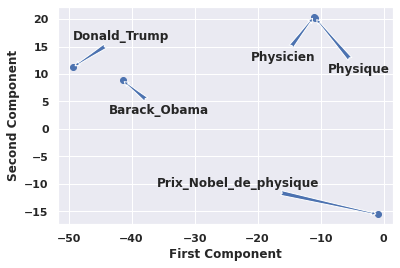

In [200]:
fr_ids = [list(Fr_shallom_embs_v1.index).index(e) for e in chosen_entities.values()]
names = [e.split('/')[-1] for e in chosen_entities.values()]
x_i = reduced_embs_fr[fr_ids,0]
y_i = reduced_embs_fr[fr_ids,1]

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots()
ax.scatter(x_i, y_i);
ax.annotate(names[0], (x_i[0], y_i[0]), xytext=(x_i[0]-2.2, y_i[0]-6), 
    arrowprops=dict(arrowstyle="fancy"))

ax.annotate(names[1], (x_i[1], y_i[1]), xytext=(x_i[1]-35, y_i[1]+5), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[2], (x_i[2], y_i[2]), xytext=(x_i[2]-0.1, y_i[2]+5), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[3], (x_i[3], y_i[3]), xytext=(x_i[3]+2, y_i[3]-10), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[4], (x_i[4], y_i[4]), xytext=(x_i[4]-10, y_i[4]-8),
    arrowprops = dict(arrowstyle="fancy"))
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.savefig("fr_tsne.pdf", bbox_inches='tight')
plt.show()

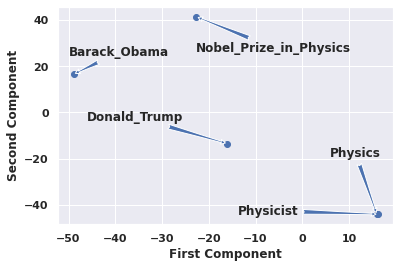

In [205]:
en_ids = [list(En_shallom_embs_v1.index).index(e) for e in chosen_entities]
names = [e.split('/')[-1] for e in chosen_entities]
x_i = reduced_embs_en[en_ids,0]
y_i = reduced_embs_en[en_ids,1]

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots()
ax.scatter(x_i, y_i);
ax.annotate(names[0], (x_i[0], y_i[0]), xytext=(x_i[0]-1, y_i[0]+8), 
    arrowprops=dict(arrowstyle="fancy"))

ax.annotate(names[1], (x_i[1], y_i[1]), xytext=(x_i[1], y_i[1]-15), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[2], (x_i[2], y_i[2]), xytext=(x_i[2]-30, y_i[2]+10), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[3], (x_i[3], y_i[3]), xytext=(x_i[3]-10, y_i[3]+25), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[4], (x_i[4], y_i[4]), xytext=(x_i[4]-30, y_i[4]),
    arrowprops = dict(arrowstyle="fancy"))
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.savefig("en_tsne.pdf", bbox_inches='tight')
plt.show()

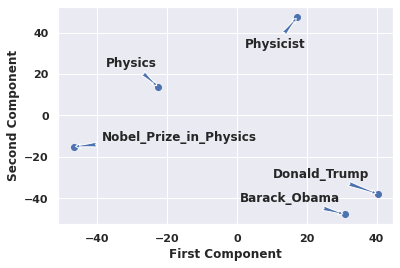

In [218]:
en_ids = [list(En_shallom_embs_v1.index).index(e) for e in chosen_entities]
names = [e.split('/')[-1] for e in chosen_entities]
x_i = reduced_uni_embs[en_ids,0]
y_i = reduced_uni_embs[en_ids,1]

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots()
ax.scatter(x_i, y_i);

ax.annotate(names[0], (x_i[0], y_i[0]), xytext=(x_i[0]-30, y_i[0]+6), 
    arrowprops=dict(arrowstyle="fancy"))

ax.annotate(names[1], (x_i[1], y_i[1]), xytext=(x_i[1]+8, y_i[1]+3), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[2], (x_i[2], y_i[2]), xytext=(x_i[2]-30, y_i[2]+8), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[3], (x_i[3], y_i[3]), xytext=(x_i[3]-15, y_i[3]+10), 
    arrowprops = dict(arrowstyle="fancy"))

ax.annotate(names[4], (x_i[4], y_i[4]), xytext=(x_i[4]-15, y_i[4]-15), 
    arrowprops = dict(arrowstyle="fancy"))
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.savefig("universal_tsne.pdf", bbox_inches='tight')
plt.show()

In [207]:
names

['Barack_Obama',
 'Nobel_Prize_in_Physics',
 'Donald_Trump',
 'Physics',
 'Physicist']